In [2]:
from sympy import symbols, init_printing
import sympy
import sympy.physics.mechanics as me
init_printing(use_latex='mathjax')
import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
import matplotlib.pyplot as plt
from scipy.integrate import ode
import numpy as np
%matplotlib notebook

In [3]:
# Create the variables
x, y, beta = me.dynamicsymbols('x, y, beta')

# Create the velocities
x_dot, y_dot, beta_dot = me.dynamicsymbols('x, y, beta', 1)

# Create the constants
m, k, L, g, H, c, D,t, Izz, k_beta, c_beta = sympy.symbols('m k L g H c D t Izz k_beta c_beta')
# m = mass
# k = spring k
# L = spring equilibrium length
# g = gravity
# c = spring c
# c_beta = rotational c
# k_beta = rotational k
# D = rod length
# Izz = moment of Inertia about the end of a rod

In [4]:
# Create the world frame
N = me.ReferenceFrame('N')

# Create the rod frame
B = N.orientnew('B', 'axis', [beta, N.z])

# Set the rotation of the rod frame
B.set_ang_vel(N, beta_dot * N.z)

# Create the Origin
O1 = me.Point('O_1')

# Set origin velocity to zero
O1.set_vel(N, 0 * N.x)

# Create the second attachment point
O2 = O1.locatenew('O_2', H * N.x)
O2.set_vel(N, 0 * N.x)

# Locate the point in the N frame
# P = me.Point('pen')
P = O1.locatenew('P', x * N.x + y * N.y)

# P.set_pos(O1, x * N.x + y * N.y)

# Set the point's velocity
P.set_vel(N, x_dot * N.x + y_dot * N.y)

# Create the rod center of mass
G = P.locatenew('G', -D/2 * B.y)

# Set the velocity of G
G.v2pt_theory(P, N, B)

# Create the rod
I_rod = me.inertia(B, 0, 0, Izz)
rod = me.RigidBody('rod', G, B, m, (I_rod, G))

# Create the distance from the point to each attachment point
L1 = O1.pos_from(P).magnitude
L2 = O2.pos_from(P).magnitude
L1_vector = O1.pos_from(P).normalize
L2_vector = O2.pos_from(P).normalize

h = G.pos_from(O1) & N.y

# Create the Particle just for testing
# Pp = me.Particle('Pp', P, m)
# Gp = me.Particle('Gp', G, m)

# forceP = (k * (L1() - L) * L1_vector() + 
#           k * (L2() - L) * L2_vector() - 
#           c * x_dot * N.x - 
#           c * y_dot * N.y)

forceP = c * (x_dot - y_dot) * L1_vector() - c * (x_dot + y_dot) * L2_vector()
# forceP = -c * x_dot * N.x - c * y_dot * N.y

forceB = c * beta_dot * N.z

rod.set_potential_energy(m * g * h + 0.5 * k * (L1() - L)**2 + 0.5 * k *(L2() - L)**2 + 0.5*k_beta*beta**2)
# rod.set_potential_energy(-m * g * h)
Lag = me.Lagrangian(N, rod)

In [5]:
x_eq = (sympy.diff(sympy.diff(Lag, x_dot), t) + sympy.diff(-0.5 * c * x_dot**2, x_dot) - sympy.diff(Lag, x))

In [7]:
y_eq = (sympy.diff(sympy.diff(Lag, y_dot), t) + sympy.diff(0.5 * c * y_dot**2, y_dot) - sympy.diff(Lag, y))
y_eq = y_eq.subs({(x,'x'), (y,'y'), (y_dot, 'y_dot'), (x_dot, 'x_dot')})
y_eq

                                                                              
                                                                              
                            ⎛        _________⎞           ⎛        ___________
                            ⎜       ╱  2    2 ⎟           ⎜       ╱  2        
                    1.0⋅k⋅y⋅⎝-L + ╲╱  x  + y  ⎠   1.0⋅k⋅y⋅⎝-L + ╲╱  y  + (H - 
1.0⋅c⋅y_dot + g⋅m + ─────────────────────────── + ────────────────────────────
                               _________                     _______________  
                              ╱  2    2                     ╱  2          2   
                            ╲╱  x  + y                    ╲╱  y  + (H - x)    

          ⎛              2                               2              ⎞
          ⎜             d                      ⎛d       ⎞      d        ⎟
____⎞   m⋅⎜D⋅sin(β(t))⋅───(β(t)) + D⋅cos(β(t))⋅⎜──(β(t))⎟  + 2⋅──(y_dot)⎟
  2 ⎟     ⎜              2                     ⎝dt      ⎠      dt 

In [76]:
beta_eq = (sympy.diff(sympy.diff(Lag, beta_dot), t) + sympy.diff(0.5 * c_beta * beta_dot**2, beta_dot) - 
           sympy.diff(Lag, beta))

In [77]:
LM = me.LagrangesMethod(Lag, [x, y, beta], forcelist=[(P, forceP), (B, forceB)], frame=N)

In [78]:
EqMotion = LM.form_lagranges_equations()
# sympy.simplify(EqMotion)

In [89]:
lrhs = LM.rhs()

In [80]:
length_of_rod = 1.0
mass = 1.0
inertia = length_of_rod * (1.0/3.0) * mass

In [81]:
# Define the states and state vector
w1, w2, w3, w4, w5, w6 = sympy.symbols('w1 w2 w3 w4 w5 w6', cls=sympy.Function)
w = [w1(t), w2(t), w3(t), w4(t), w5(t), w6(t)]

# Set up the state definitions and parameter substitution
sub_params = {x : w1(t),
              y : w2(t),
              beta: w3(t),
              x_dot: w4(t),
              y_dot: w5(t),
              beta_dot: w6(t),
              m : mass,
              g : 9.81,
              k : 10.0,
              L : 15.0,
              H : 10.0,
              c : 10.0,
              D : length_of_rod,
              Izz: inertia,
              k_beta: 0.0,
              c_beta: 0.0}

# set this parameter to enable array output from sympy.lambdify
mat2array = [{'ImmutableMatrix': np.array}, 'numpy']

# Create a function from the equations of motion
# Here, we substitude the states and parameters as appropriate prior to the lamdification
eq_of_motion = sympy.lambdify((t, w), 
                              lrhs.subs(sub_params), 
                              modules = mat2array)

In [82]:
end_time = 30.0

x0 = [5, 13, 0.8, 0.0, 0.0, 0.0]
sim_time = np.linspace(0.0, end_time, 900)

In [83]:
# Set up the initial point for the ode solver
r = ode(eq_of_motion).set_initial_value(x0, sim_time[0])
 
# define the sample time
dt = sim_time[1] - sim_time[0]   

# pre-populate the response array with zeros
response = np.zeros((len(sim_time), len(x0)))

# Set the initial index to 0
index = 0

# Now, numerically integrate the ODE while:
#   1. the last step was successful
#   2. the current time is less than the desired simluation end time
while r.successful() and r.t < sim_time[-1]:
    response[index, :] = r.y
    r.integrate(r.t + dt)
    index += 1

<IPython.core.display.Javascript object>


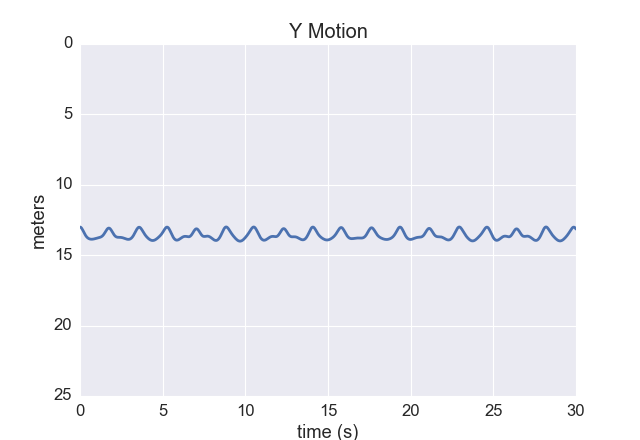

<IPython.core.display.Javascript object>


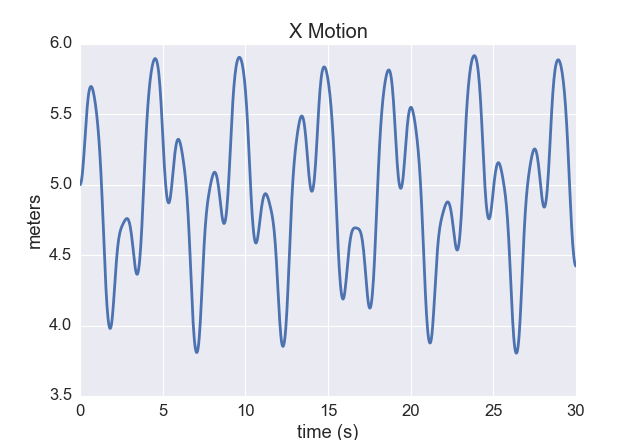

<IPython.core.display.Javascript object>


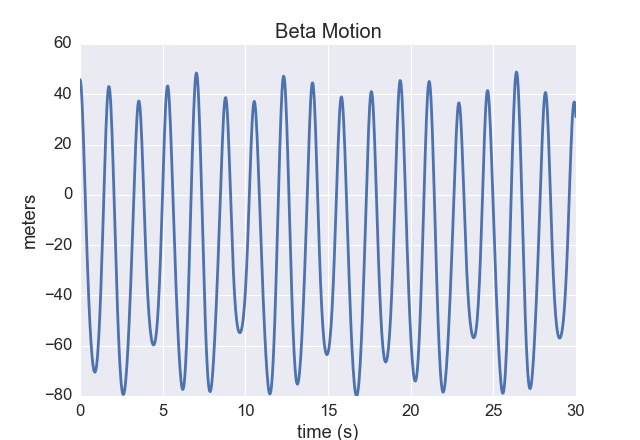

<IPython.core.display.Javascript object>


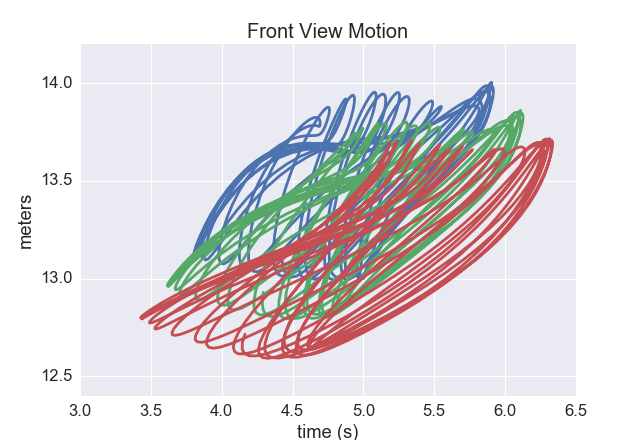

In [84]:
plt.figure(0)
# plt.subplot(211)
plt.plot(sim_time, response[:,1])
plt.ylim(25,0)
plt.title('Y Motion')
plt.xlabel('time (s)')
plt.ylabel('meters')

plt.figure(1)
# plt.subplot(211)
plt.plot(sim_time, response[:,0])
plt.title('X Motion')
plt.xlabel('time (s)')
plt.ylabel('meters')

plt.figure(2)
# plt.subplot(211)
plt.plot(sim_time, np.degrees(response[:,2]))
plt.title('Beta Motion')
plt.xlabel('time (s)')
plt.ylabel('meters')

plt.figure(3)
# plt.subplot(212)
plt.plot(response[:,0], response[:,1])
plt.plot(response[:,0] - 0.5/2 * np.sin(response[:,2]) , response[:,1] - 0.5/2 * np.cos(response[:,2]))
plt.plot(response[:,0] - 1/2 * np.sin(response[:,2]) , response[:,1] - 1/2 * np.cos(response[:,2]))
plt.title('Front View Motion')
plt.xlabel('time (s)')
plt.ylabel('meters')
# plt.show()

In [ ]:
# def eq_of_motion(w, t, p):
#     """
#     Defines the differential equations for the coupled spring-mass system.

#     Arguments:
#         w :  vector of the state variables:
#                   w = [x, theta, x_dot, theta_dot]
#         t :  time
#         p :  vector of the parameters:
#                   p = [m1, m2, k, l, g, wf]
    
#     Returns:
#         sysODE : An list representing the system of equations of motion as 1st order ODEs
#     """
#     x, y, beta, x_dot, y_dot, beta_dot = w
#     m, k, L, g, t, H, c, D, Izz = p

#     # Create sysODE = (x', theta', x_dot', theta_dot'):
#     sysODE = [x_dot,
#               y_dot,
#               beta_dot,
#               x_eq,
#               y_eq,
#               beta_eq]
    
#     return sysODE

In [ ]:
# # Set up simulation parameters 
# m= 1 
# k= 10 
# L = 10 
# g= 9.81 
# H=10 
# c =1.0 
# D=0.2 
# Izz = 1.0
# # ODE solver parameters
# abserr = 1.0e-9
# relerr = 1.0e-9
# max_step = 0.01
# stoptime = 25.0
# numpoints = 1000

# # Create the time samples for the output of the ODE solver
# t = np.linspace(0.0, stoptime, numpoints)

# # Initial conditions
# x_init = 0.0                        # initial position
# x_dot_init = 0.0                    # initial velocity
# y_init = 1.0                    # initial angle
# y_dot_init = 0.0                # initial angular velocity
# beta_init = 0.0                        # initial position
# beta_dot_init = 0.0 

# # wf = np.np.sqrt(k / m1)                # forcing function frequency

# # Pack the parameters and initial conditions into arrays 
# p = [m, k, L, g, t, H, c, D, Izz]
# x0 = [x_init, y_init, beta_init, x_dot_init, y_dot_init, beta_dot_init]
# resp = odeint(eq_of_motion, x0, t, args=(p,), atol=abserr, rtol=relerr,  hmax=max_step)